In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os
import glob

In [2]:
ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

In [3]:
#Note 1/18/23: Flux tower footprint (fluxproper) OR expanded flux area (fluxdiss) OR all gce (gce_clip)

gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_sapelodissolve.shp'

gce_fluxdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_fluxdissolve.shp'

gce_fluxproper = 'F:/Wetlands shapefiles/GCE flux tower/2014-climatology.shp'

gce_expandedflux = 'F:/Wetlands shapefiles/GCE flux tower/expanded_flux.shp' ## Added 9/18/23 - fix shapefile problems!

flux_ga = geemap.shp_to_ee(gce_expandedflux)

## DEM
elevation = ee.Image('USGS/3DEP/10m').clip(flux_ga) ##This is 1/3 arc second, or 10 m.

In [4]:
##FLATS

#12/08/22 - add calibrated flats to images
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

In [5]:
# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)


#Function to add elevation

def add_elevation(image):
    elevation_band = elevation.rename('elevation')
    return image.addBands(elevation_band)

In [6]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [7]:
#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band).map(add_elevation)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band).map(add_elevation)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band).map(add_elevation)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band).map(add_elevation)

In [8]:
#Percentage of pixels in study area flagged, Landsat 8

study_area = flux_ga.geometry()

# Define the threshold value
threshold = 0.2

# Function to calculate binary image for 'flats' values greater than the threshold
def calculate_binary_image(image):
    flats_band = image.select('flats')
    binary_image = flats_band.gt(threshold)
    return binary_image

# Map the function over the collection to get binary images
binary_images = l8_col.map(calculate_binary_image)

# Function to count valid pixels
def count_valid_pixels(image):
    valid_pixel_count = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=study_area,
        scale=30  # Assuming 30-meter resolution
    ).get('flats')
    return image.set('valid_pixel_count', valid_pixel_count)

# Map the function over the binary images to count valid pixels
binary_images_with_count = binary_images.map(count_valid_pixels)

# Filter the collection to exclude scenes with fewer than 100 valid pixels
filtered_images = binary_images_with_count.filter(ee.Filter.gte('valid_pixel_count', 110))

# Reduce the filtered collection to a single image with pixel count
total_count_image = filtered_images.sum()

# Calculate the percentage of times each pixel exceeded the threshold
total_images = filtered_images.size()
percentage_image = total_count_image.divide(total_images).multiply(100)

# Display the percentage image on the map
# Map = geemap.Map()
# Map.centerObject(flux_ga, 8)
# Map.addLayer(percentage_image, {
#     'min': 0,
#     'max': 100,
#     'palette': ['red', 'yellow', 'green']
# }, 'Percentage of Times > 0.2')
# Map

In [67]:
ultra_col = l8_col.merge(l5_col).merge(l7_col).merge(l9_col)

ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).filterBounds(flux_ga)

#Percentage of pixels in study area flagged, ALL =----= MIGHT BE A BETTER WAY TO DO THIS

study_area = flux_ga.geometry()

# Define the threshold value
threshold = 0.2

# Function to calculate binary image for 'flats' values greater than the threshold
def calculate_binary_image(image):
    flats_band = image.select('flats')
    binary_image = flats_band.gt(threshold)
    return binary_image

# Map the function over the collection to get binary images
binary_images = ultra.map(calculate_binary_image)

# Function to count valid pixels
def count_valid_pixels(image):
    valid_pixel_count = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=study_area,
        scale=30  # Assuming 30-meter resolution
    ).get('flats')
    return image.set('valid_pixel_count', valid_pixel_count)

# Map the function over the binary images to count valid pixels
binary_images_with_count = binary_images.map(count_valid_pixels)

# Filter the collection to exclude scenes with fewer than 100 valid pixels
filtered_images = binary_images_with_count.filter(ee.Filter.gte('valid_pixel_count', 110))

# Reduce the filtered collection to a single image with pixel count
total_count_image = filtered_images.sum()

# Calculate the percentage of times each pixel exceeded the threshold
total_images = filtered_images.size()
percentage_image = total_count_image.divide(total_images).multiply(100)

Map = geemap.Map()
Map.centerObject(flux_ga, 8)
Map.addLayer(percentage_image, {
    'min': 0,
    'max': 100,
    'palette': ['red', 'yellow', 'green']
}, 'Percentage of Times > 0.2')
# Map

In [68]:
#Directory
out_dir = os.path.join("F:/Flats imagery")
##Draw geometry for exported images! It will look better

bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

image = percentage_image
filename = os.path.join(out_dir, '2014percent2023.tif')

image = image.clip(bb).unmask()

# geemap.ee_export_image(
#     image.select('flats'), filename=filename, scale=30, region=flux_ga.geometry(), file_per_band=True
# )


Generating URL ...
Please wait ...
Data downloaded to F:\Flats imagery


In [154]:
##ALSO MAP: PERCENT TIME FLAGGED AS CLOUDY, PREFILTERED
##STRIPING DUE TO L7s
#Loading gee datasets
l8_unf = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)

l7_unf = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)

l5_unf = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)

l9_unf = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)

ultra_unfiltered = l8_unf.merge(l5_unf).merge(l9_unf) #Took out l7 due to striping!

def calculate_cloud_mask(image):
    qa_pixel = image.select('QA_PIXEL')  # QA_PIXEL band for Landsat 8 Collection 2
    return qa_pixel.bitwiseAnd(int('11111', 2)).eq(0)

# Map the function over the image collection to get binary cloud masks
cloud_masks = ultra_unfiltered.map(calculate_cloud_mask)

# Reduce the collection to compute the sum of binary cloud masks for each pixel
sum_cloud_masks = cloud_masks.reduce(ee.Reducer.sum())

# Calculate the percentage of times each pixel is cloudy
total_images = ultra_unfiltered.size()
percentage_cloudy = sum_cloud_masks.divide(total_images).multiply(100)

Map = geemap.Map()
Map.centerObject(flux_ga, 8)
Map.addLayer(percentage_cloudy, {
    'min': 0,
    'max': 100,
    'palette': ['red', 'orange', 'yellow', 'blue', 'green']
}, 'Percentage of times cloudy')

# Map

EPSG:4326


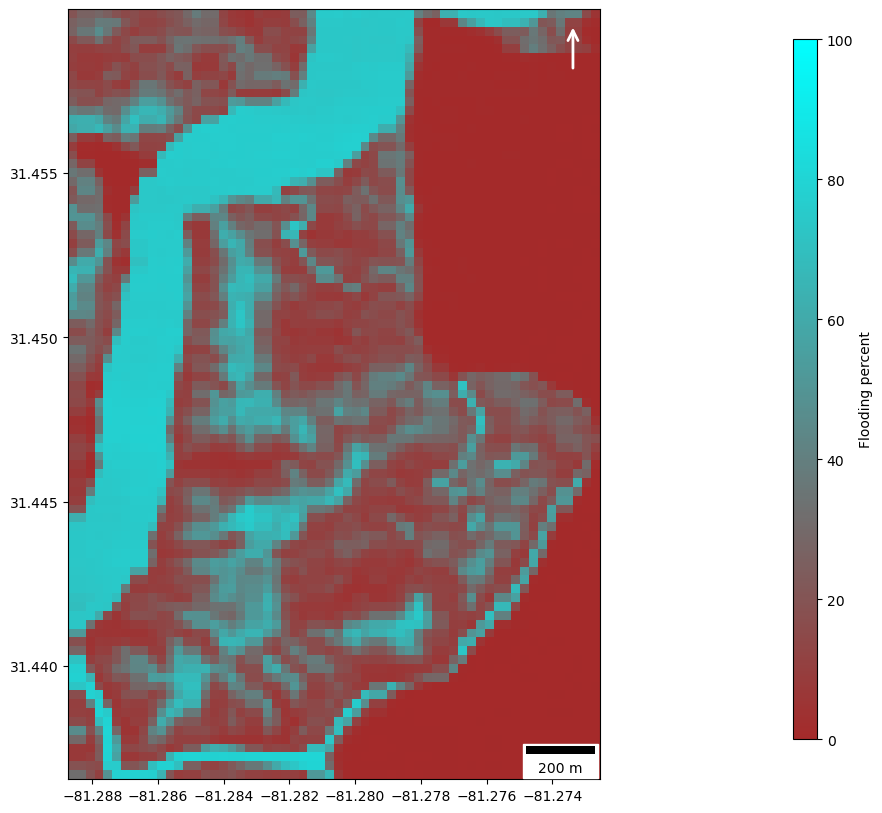

In [117]:
#Plotting
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar
import rasterio
import geopandas as gpd

geotiff_path = "F:/Flats imagery/1984percentflats2023.flats.tif"

#Calculating dx for scale_bar
from geopy.distance import great_circle
point1 = (31.425,-81.29) 
point2 = (31.425,-80.29)  
dx = great_circle(point1, point2).meters

with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)    
        
        # Use a colormap with better visibility
        cmap = colors.LinearSegmentedColormap.from_list('custom', [(0, 'brown'), (1, 'aqua')])
        
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,10))
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data, extent=extent, cmap=cmap, vmin=0, vmax=100)

        # Remove coordinate labels to make the plots larger
#         ax.set_xticks([])
#         ax.set_yticks([])

        # Add a scale bar
        # Calculate the scale factor based on the pixel size (assuming meters)
        pixel_size_x = 30  # 30 meters in the x-direction
        scale_factor = pixel_size_x

        # Add a scale bar using the calculated scale factor
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))
        
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax, label = 'Flooding percent', cmap = \
                          colors.LinearSegmentedColormap.from_list('custom_gray', [(0, 'brown'), (1, 'aqua')]))
        
        
print(src.crs)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('1983percent2023.png',bbox_inches='tight', dpi = 300)


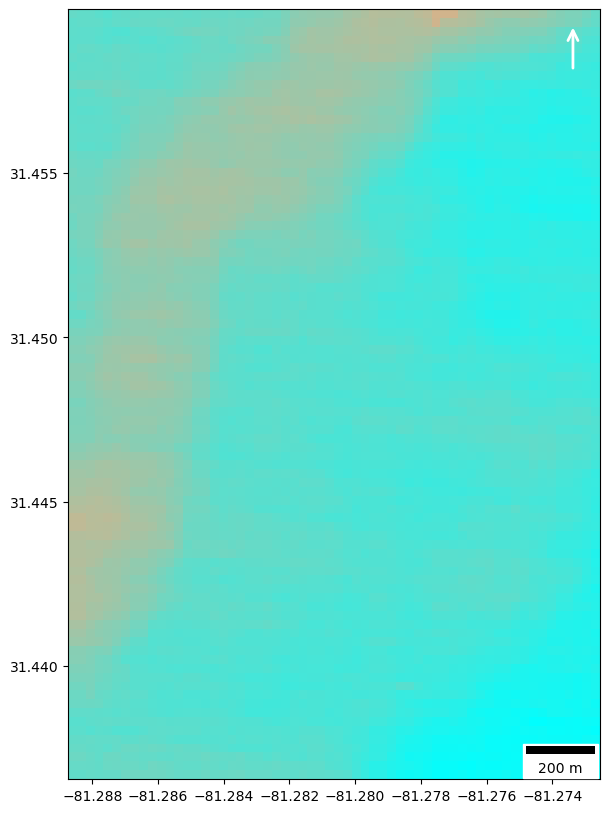

In [128]:
#Plotting clouds

geotiff_path = "F:/Flats imagery/1984clouds2023.QA_PIXEL_sum.tif"

#Calculating dx for scale_bar
from geopy.distance import great_circle
point1 = (31.425,-81.29) 
point2 = (31.425,-80.29)  
dx = great_circle(point1, point2).meters

with rasterio.open(geotiff_path) as src:
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    
        # Use a colormap with better visibility
        cmap = colors.LinearSegmentedColormap.from_list('custom', [(0, 'tan'), (1, 'aqua')])
        
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,10))
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data, extent=extent, cmap=cmap)

        # Remove coordinate labels to make the plots larger
#         ax.set_xticks([])
#         ax.set_yticks([])

        # Add a scale bar
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))
        
    
    
#STRIPING DUE TO LANDSAT 7

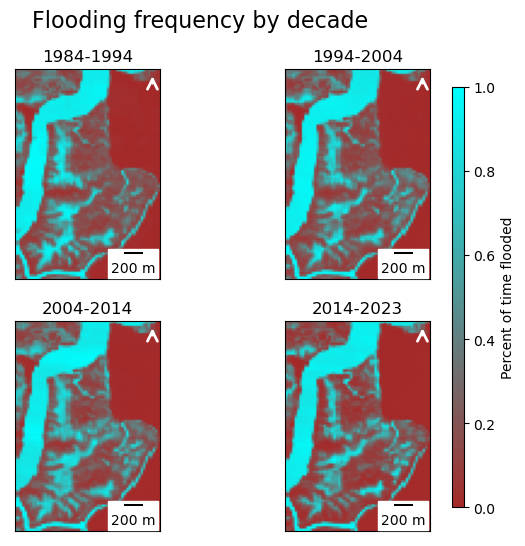

In [126]:
import matplotlib.pyplot as plt
import rasterio
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
import numpy as np

dec84 = 'F:/Flats imagery/1984percent1994.flats.tif'
dec94 = 'F:/Flats imagery/1994percent2004.flats.tif'
dec04 = 'F:/Flats imagery/2004percent2014.flats.tif'
dec14 = 'F:/Flats imagery/2014percent2023.flats.tif'

dec_paths = [dec84, dec94, dec04, dec14]

#Calculating dx for scale_bar
from geopy.distance import great_circle
point1 = (31.425,-81.29) 
point2 = (31.425,-80.29)  
dx = great_circle(point1, point2).meters

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        # Adjust the contrast by using a gamma correction
        gamma = 1  # Experiment with different gamma values
        data = data ** gamma
        
        # Normalize the data to the range [0, 1]
        data_normalized = (data - np.min(data)) / (np.max(data) - np.min(data))
        
        # Create a custom colormap that maps values from 0 to 1 to colors
        cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, 'brown'), (1, 'aqua')])
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=0, vmax=1)

        # Remove coordinate labels to make the plots larger
        ax.set_xticks([])
        ax.set_yticks([])

        # Add a scale bar
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))

        # Set subplot title
        ax.set_title(title)
        
        return im  # Return the im object

# Create a figure and subplots with adjusted size
fig, axs = plt.subplots(2, 2, figsize=(6, 6))  # Increased figsize

# Initialize im objects
ims = []

# Define titles for each subplot
titles = ['1984-1994', '1994-2004', '2004-2014', '2014-2023']

# Plot each GeoTIFF image with its corresponding title
for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(dec_paths[i], ax, titles[i])
    ims.append(im)

# Add a title for the entire figure (optional)
plt.suptitle('Flooding frequency by decade', fontsize=16)

# Create a colorbar for the last im object
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(ims[-1], cax=cbar_ax, label='Percent of time flooded', cmap=cmap)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('fig.png',bbox_inches='tight', dpi=300)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('decadespercent.png',bbox_inches='tight', dpi = 300)

# Adjust layout and display the plot
plt.show()

In [140]:
#Filtering by month

ultra_col = l8_col.merge(l5_col).merge(l7_col).merge(l9_col)

ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filter(ee.Filter.calendarRange(12, 12, 'month')) \
    .filterBounds(flux_ga)

#Percentage of pixels in study area flagged, ALL =----= MIGHT BE A BETTER WAY TO DO THIS

study_area = flux_ga.geometry()

# Define the threshold value
threshold = 0.2

# Function to calculate binary image for 'flats' values greater than the threshold
def calculate_binary_image(image):
    flats_band = image.select('flats')
    binary_image = flats_band.gt(threshold)
    return binary_image

# Map the function over the collection to get binary images
binary_images = ultra.map(calculate_binary_image)

# Function to count valid pixels
def count_valid_pixels(image):
    valid_pixel_count = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=study_area,
        scale=30  # Assuming 30-meter resolution
    ).get('flats')
    return image.set('valid_pixel_count', valid_pixel_count)

# Map the function over the binary images to count valid pixels
binary_images_with_count = binary_images.map(count_valid_pixels)

# Filter the collection to exclude scenes with fewer than 100 valid pixels
filtered_images = binary_images_with_count.filter(ee.Filter.gte('valid_pixel_count', 110))

# Reduce the filtered collection to a single image with pixel count
total_count_image = filtered_images.sum()

# Calculate the percentage of times each pixel exceeded the threshold
total_images = filtered_images.size()
percentage_image = total_count_image.divide(total_images).multiply(100)

Map = geemap.Map()
Map.centerObject(flux_ga, 8)
Map.addLayer(percentage_image, {
    'min': 0,
    'max': 100,
    'palette': ['red', 'yellow', 'green']
}, 'Percentage of Times > 0.2')
# Map

image = percentage_image
filename = os.path.join(out_dir, 'dec.tif')

image = image.clip(bb).unmask()

# geemap.ee_export_image(
#     image.select('flats'), filename=filename, scale=30, region=flux_ga.geometry(), file_per_band=True
# )

Generating URL ...
Please wait ...
Data downloaded to F:\Flats imagery


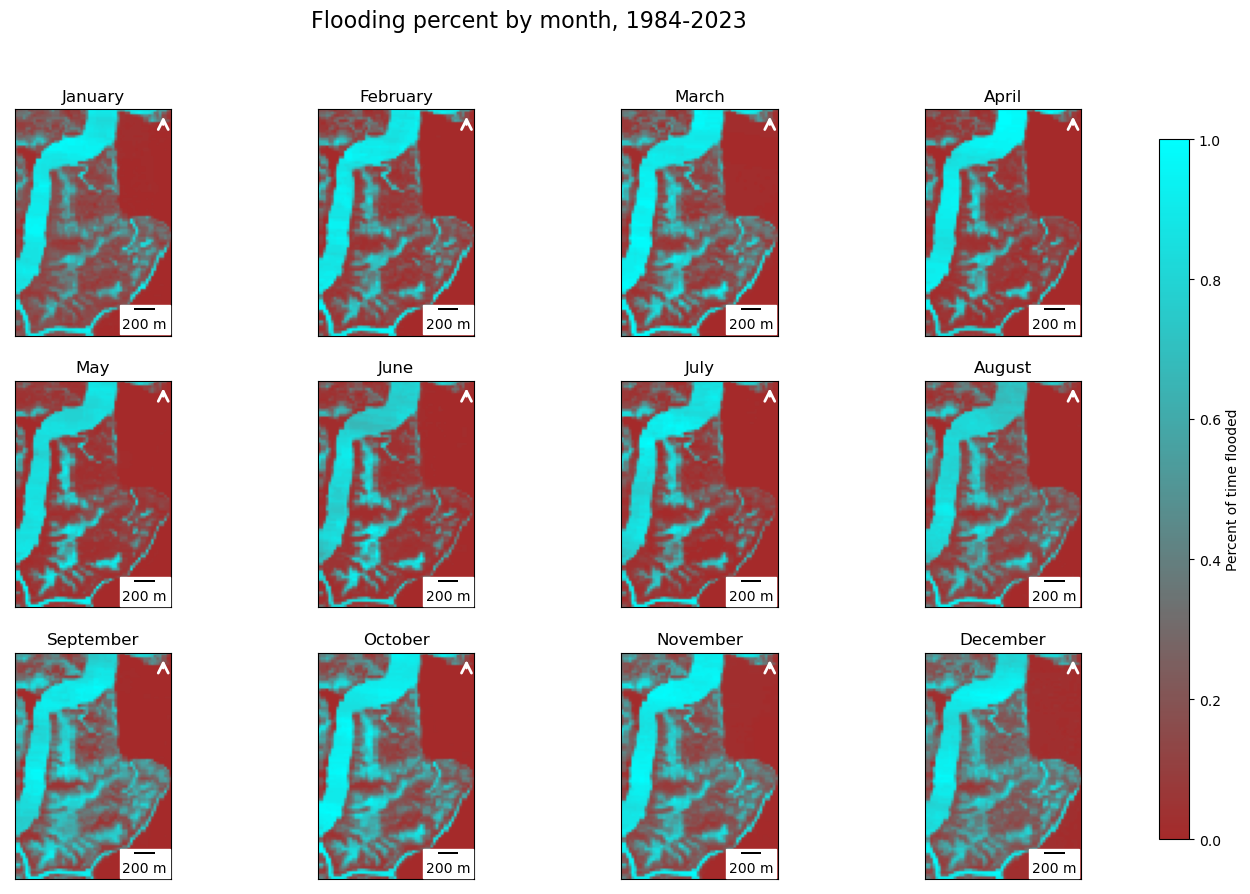

In [152]:
jan = 'F:/Flats imagery/jan.flats.tif'
feb = 'F:/Flats imagery/feb.flats.tif'
mar = 'F:/Flats imagery/mar.flats.tif'
apr = 'F:/Flats imagery/apr.flats.tif'
may = 'F:/Flats imagery/may.flats.tif'
jun = 'F:/Flats imagery/jun.flats.tif'
jul = 'F:/Flats imagery/jul.flats.tif'
aug = 'F:/Flats imagery/aug.flats.tif'
sep = 'F:/Flats imagery/sep.flats.tif'
m_oct = 'F:/Flats imagery/oct.flats.tif'
nov = 'F:/Flats imagery/nov.flats.tif'
dec = 'F:/Flats imagery/dec.flats.tif'

month_paths = [jan,feb,mar,apr,may,jun,jul,aug,sep,m_oct,nov,dec]

#Calculating dx for scale_bar
from geopy.distance import great_circle
point1 = (31.425,-81.29) 
point2 = (31.425,-80.29)  
dx = great_circle(point1, point2).meters

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        # Adjust the contrast by using a gamma correction
        gamma = 1  # Experiment with different gamma values
        data = data ** gamma
        
        # Normalize the data to the range [0, 1]
        data_normalized = (data - np.min(data)) / (np.max(data) - np.min(data))
        
        # Create a custom colormap that maps values from 0 to 1 to colors
        cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, 'brown'), (1, 'aqua')])
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=0, vmax=1)

        # Remove coordinate labels to make the plots larger
        ax.set_xticks([])
        ax.set_yticks([])

        # Add a scale bar
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))

        # Set subplot title
        ax.set_title(title)
        
        return im  # Return the im object

# Create a figure and subplots with adjusted size
fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # Increased figsize

# Initialize im objects
ims = []

# Define titles for each subplot
titles = ['January', 'February', 'March', 'April','May','June','July','August','September','October','November','December']

# Plot each GeoTIFF image with its corresponding title
for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(month_paths[i], ax, titles[i])
    ims.append(im)

# Add a title for the entire figure (optional)
plt.suptitle('Flooding percent by month, 1984-2023', fontsize=16)

# Create a colorbar for the last im object
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(ims[-1], cax=cbar_ax, label='Percent of time flooded', cmap=cmap)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('fig.png',bbox_inches='tight', dpi=300)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('monthspercent.png',bbox_inches='tight', dpi = 300)

# Adjust layout and display the plot
plt.show()

In [155]:
#Adding tide
import glob
import pandas as pd

# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

path = r'C:/Users/arj26323/Documents/Data/flats/Tide data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df

df2 = df.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])


time_mask = (df2['Time (GMT)'].dt.hour == 16)

df_time = df2[time_mask]

df_time

# conditions_A = [ df1['Tide_A'] >= 0.9, (df1['Tide_A'] < 0.9) & (df1['Tide_A']> -1.1), df1['Tide_A'] <= -1.1 ]
# conditions_B = [ df1['Tide_B'] >= 0.9, (df1['Tide_B'] < 0.9) & (df1['Tide_B']> -1.1), df1['Tide_B'] <= -1.1 ]
# choices = [ "Flood", 'Mid', 'Ebb' ]

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m),DOY
16,1985/01/02,2023-09-26 16:00:00,0.340,-,0.479,1985-01-02
40,1985/01/03,2023-09-26 16:00:00,0.275,-,0.406,1985-01-03
64,1985/01/04,2023-09-26 16:00:00,0.374,-,0.458,1985-01-04
88,1985/01/05,2023-09-26 16:00:00,0.620,-,0.543,1985-01-05
112,1985/01/06,2023-09-26 16:00:00,0.967,-,1.162,1985-01-06
...,...,...,...,...,...,...
350536,1984/12/28,2023-09-26 16:00:00,1.759,-,1.83,1984-12-28
350560,1984/12/29,2023-09-26 16:00:00,1.466,-,1.449,1984-12-29
350584,1984/12/30,2023-09-26 16:00:00,1.148,-,1.104,1984-12-30
350608,1984/12/31,2023-09-26 16:00:00,0.835,-,0.927,1984-12-31


In [172]:
df_time = df_time.loc['1984-01-01':'2023-09-26']

def add_verified_m(image):
    # Get the date from the image
    date = ee.Date(image.get('system:time_start'))
    
    # Extract the DOY from the date
    doy = date.get('day_of_year')
    
    # Filter the DataFrame to find the matching row(s)
    match = df_time[df_time['DOY'] == doy]
    
        # Get the 'Verified_m' value from the first matching row
    verified_m = match['Verified (m)'].values[0]
        
        # Add the 'Verified_m' value as a property to the image
    return image.set('Verified (m)', verified_m)

# Map the function over the image collection
ultra_tide = ultra_col.map(add_verified_m)

IndexError: index 0 is out of bounds for axis 0 with size 0